<a href="https://colab.research.google.com/github/Himagination/TensorFlow_Developer/blob/main/07_NLP_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network.

RNN's are useful for sequence data.

The premise of a Recurrent Neural Network is to use the representation of a previous input to aid the representation a later input.

**Typical Architecture of RNN**

* Input text(s): Target texts/sequence you'd like to discover patterns in
* Input Layer: Takes in target sequence
* Text Vectorization layer: Maps Input Sequences to numbers.
* Embedding: Turns mapping of text vectors to embedding matrix(representation of how words relate)
* RNN Cell(s): Find patterns in sequences.
* Hidden Activation: Adds non-linearity to learned features(non-straight line)
* Pooling Layer: Reduces the dimensionality of learned sequence features(usually for Conv1D modules)
* Fully Connected Layer: Further refines learned features from recurrent layers.
* Output layer: Takes Learned features and outputs them in shape of target labels.
* Output activation: Adds non-linearities to output layer.

# Introduction to NLP fundamentals

NLP has the goal of deriving information out of natural language(could be sequences text or speech)

Another common term for NLP problems is sequences problems(seq2seq)

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2d1b3150-5eb1-65ae-b3ea-5c4c9f533eaa)


## Writing Helper Functions

- unzip_data: Unzips filename into the current working directory
- create_tensorboard_callback: Creates a TensorBoard callback instead to store log files
- plot_loss_curves: Returns Separate Loss Curves for training and Validation metrics
- compare_historys: Compares two TensorFlow model History Objects

### unzip_data

In [1]:
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory

  Args:
    filename(str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

### create_tensorboard_callback

In [2]:
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instance to store log files

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

### plot_loss_curves

In [3]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns Separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object
  """

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss")
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

## Get a dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset(Text sample of Tweets labelled as disaster or not disaster).

url: https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2022-01-21 22:20:47--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.13.128, 74.125.26.128, 172.217.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.13.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2022-01-21 22:20:47 (120 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Becoming one with data

In [5]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df['text'][2]

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

In [7]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
# How many total sample?
len(train_df), len(test_df)

(7613, 3263)

In [11]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df) - 5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
Emergency Flow  http://t.co/lH9mrYpDrJ mp3 http://t.co/PqhuthSS3i rar http://t.co/0iW6dRf5X9

---

Target: 0 (not real disaster)
Text:
@soonergrunt better than tornado!

---

Target: 0 (not real disaster)
Text:
Anyone else getting tons of telemarketing calls on their cell phone? I've been deluged!

---

Target: 0 (not real disaster)
Text:
@MaatMHI Slightly diff catastrophe &amp; Barry was running solo but generally the same thing.

---

Target: 1 (real disaster)
Text:
Strong Thunderstorm 4 Miles East of Pickens Moving NE At 20 MPH. Pea Size Hail and Wind Gusts Up to 40 MPH... #scwx http://t.co/TsaLetFtkt

---



### Split data into training and validation sets

In [12]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(), 
                                                                            train_df_shuffled['target'].to_numpy(), 
                                                                            test_size=0.1, 
                                                                            random_state=42)

In [13]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_sentences)

(6851, 6851, 762, 762)

In [14]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

When dealing with text problem, one of the first things to do is to convert texts to numbers.

There are few ways to do this, namely:
* Tokenization - direct mapping of token(a token could be a word or a character) to number.
* Embedding - create a matrix of feature vector for each token(the size of the feature vector can be defined and this embedding can be learned)


### Text Vectorization(tokenization)

In [16]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, 
                                    standardize="lower_and_strip_punctuation", 
                                    split="whitespace", 
                                    ngrams=None, 
                                    output_mode="int", 
                                    output_sequence_length=None)

In [17]:
# Find the average number of tokens(words) in the training tweets
round((sum([len(i.split()) for i in train_sentences])) / len(train_sentences))

15

In [18]:
# Setup text vectorization variables
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length, 
                                    output_mode="int", 
                                    output_sequence_length=max_length)

In [19]:
# Fit the text vectorizer to the training data
text_vectorizer.adapt(train_sentences)

In [20]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [21]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\ {random_sentence}\
\n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:\ #Metro still doesn't know when Blue &amp; Orange lines will reopen. Empty passenger car derailed ~ 5 a.m. NOT a new 7000-series. @CQnow #WMATA

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1388,   80,  629,  106,   45,  824,   35, 3555, 5216,   38, 4758,
        5731, 2810,  127,  464]])>

In [22]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 Most common words: {top_5_words}")
print(f"5 Least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 Most common words: ['', '[UNK]', 'the', 'a', 'in']
5 Least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Create an Embedding using an Embedding Layer.

To make our embedding, we're going to use TensorFlow embedding layer.

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for eg a value of 100 would mean each token gets represented by a vector of length 100
* `input_length` = length of the sequences being passed to the embedding layer

In [23]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, 
                             output_dim=128, 
                             input_length=max_length)
embedding

In [24]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
\n\nEmbedded version:")

# Embed the random sentence(turn it into dense vectors)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 @Flames_Nation that's the optimistic side of me. No doubt it's tough. But it can be done. I feel like the games will pivot on defense.

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.02195919, -0.04668758,  0.01022122, ...,  0.04236592,
          0.04868393, -0.02190541],
        [-0.00792098,  0.04172586, -0.03782749, ..., -0.0450027 ,
          0.01661532, -0.04130504],
        [ 0.00301348, -0.04617546, -0.04055146, ...,  0.03293267,
         -0.04614058, -0.04942409],
        ...,
        [ 0.01457815, -0.03131831,  0.03622314, ..., -0.04610905,
          0.04141409, -0.01969268],
        [-0.00515324,  0.02809383, -0.01953862, ..., -0.00547059,
         -0.0068722 ,  0.03572946],
        [-0.03680152, -0.02678922, -0.02139951, ..., -0.00455977,
          0.02031014, -0.04702317]]], dtype=float32)>

## Modelling a text dataset and running series of experiments.

* Experiment 0: Naive Bayes with TF-IDF encoder(Baseline)
* Experiment 1: Feed-Forward Neural Network(Dense Model)
* Experiment 2: LSTM(RNN)
* Experiment 3: GRU(RNN)
* Experiment 4: Bidirectional-LSTM(RNN)
* Experiment 5: 1D Convolutional Neural Network
* Experiment 6: TensorFlow Hub Pretrained Feature Extractor
* Experiment 7: TensorFlow Hub Pretrained Feature Extractor(10% of data)

Use the standard steps in modelling with TensorFlow
* Create a model
* Build a model
* Fit a model
* Evaluate our model

### Model 0: Getting a baseline

As with all Machine Learning modelling experiments, it's important to create a baseline model so we've got a benchmark for future experiment to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert  our words to numbers.

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), 
                    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [53]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [54]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

#### Creating an evaluation function for our model experiments

Let's create function to compare our model's prediction with the truth labels using the following:
* Accuracy
* Precision
* Recall
* F1-Score

In [59]:
# Function to evaluate: accuracy, prediction, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred, model_name):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1-score
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {"model": model_name, 
                   "accuracy": model_accuracy, 
                   "precision": model_precision, 
                   "recall": model_recall, 
                   "f1": model_f1}
  return model_results

In [61]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels, 
                                     y_pred=baseline_preds, 
                                     model_name="baseline")
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'model': 'baseline',
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: A Simple Dense Model

In [15]:
# Create a tensorboard callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [43]:
# Build Model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # Inputs are 1-dimensional strings
x = text_vectorizer(inputs)# Turn the input text into numbers
x = embedding(x) # Create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # Condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation='sigmoid')(x) # Create the output layer
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [44]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [45]:
# Compile model
model_1.compile(loss='binary_crossentropy', 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=['accuracy'])

In [46]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences, 
                              y=train_labels, 
                              epochs=5, 
                              validation_data=(val_sentences, val_labels), 
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20220121-224802
Epoch 1/5
215/215 [==============================] - 5s 19ms/step - loss: 0.5398 - accuracy: 0.8008 - val_loss: 0.5136 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3490 - accuracy: 0.8875 - val_loss: 0.4589 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.2647 - accuracy: 0.9124 - val_loss: 0.4563 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.2151 - accuracy: 0.9302 - val_loss: 0.4693 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1812 - accuracy: 0.9409 - val_loss: 0.4928 - val_accuracy: 0.7808


In [47]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4928 - accuracy: 0.7808


[0.4927883744239807, 0.7808399200439453]

In [48]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[0]

array([0.28201497], dtype=float32)

In [50]:
# Convert model prediction probabilities to label formats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [62]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds, 
                                    model_name="model_1")
model_1_results

{'accuracy': 78.08398950131233,
 'f1': 0.7782630349987989,
 'model': 'model_1',
 'precision': 0.7841274438015813,
 'recall': 0.7808398950131233}

In [63]:
# Compare by creating a dataframe
results_comp = pd.DataFrame(data=([baseline_results, model_1_results]))
results_comp

,model,accuracy,precision,recall,f1
0,baseline,79.265092,0.811139,0.792651,0.786219
1,model_1,78.083990,0.784127,0.780840,0.778263


### Visualizing learned embeddings

In [64]:
# get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [65]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [72]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights, embed_weights.shape

(array([[-0.03399761,  0.0290365 , -0.05840028, ...,  0.03829534,
          0.08915806, -0.00974675],
        [-0.05654678, -0.03625168, -0.00588135, ...,  0.08243529,
          0.05761223, -0.05376664],
        [ 0.00231245, -0.03261254, -0.07253529, ...,  0.08850341,
          0.03067583, -0.07276879],
        ...,
        [ 0.0285699 , -0.00950535,  0.00586786, ...,  0.03790274,
         -0.01129287, -0.02342602],
        [-0.12416694,  0.1279385 ,  0.09588901, ..., -0.06229327,
          0.09380976, -0.07097793],
        [-0.11332322,  0.15065764,  0.16045365, ..., -0.18687154,
          0.1488882 , -0.11663288]], dtype=float32), (10000, 128))

In [73]:
# Create embedding files(we got this from TensorFlow's word embeddings documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [74]:
# Download files from colab to upload on projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model 2: LSTM

LSTM = Long short Term Memory

Our structure of an RNN typically looks like:

```
Input(text) -> Tokenize -> Layers(RNNs/dense) -> Output (label probability)
```

In [76]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units=64, return_sequences=True)(x) # when we're stacking RNN cells together, we need to set return_sequences 
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [77]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [78]:
# Compile the model
model_2.compile(loss="binary_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=['accuracy'])

In [79]:
# Fit the model
model_2_history = model_2.fit(train_sentences, 
                              train_labels, 
                              epochs=5, 
                              validation_data=(val_sentences, val_labels), 
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220121-235401
Epoch 1/5
215/215 [==============================] - 10s 35ms/step - loss: 0.1518 - accuracy: 0.9494 - val_loss: 0.6513 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 7s 31ms/step - loss: 0.0978 - accuracy: 0.9635 - val_loss: 0.7943 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 7s 32ms/step - loss: 0.0810 - accuracy: 0.9683 - val_loss: 0.7170 - val_accuracy: 0.7808
Epoch 4/5
215/215 [==============================] - 7s 32ms/step - loss: 0.0677 - accuracy: 0.9723 - val_loss: 1.0810 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 7s 32ms/step - loss: 0.0589 - accuracy: 0.9752 - val_loss: 1.1369 - val_accuracy: 0.7703


In [80]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)>

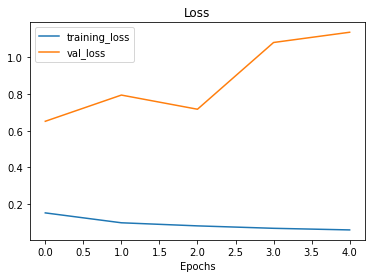

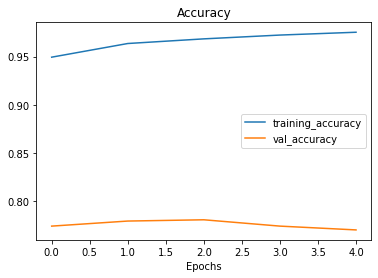

In [84]:
# Plot loss curve
plot_loss_curves(model_2_history)

In [83]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels, 
                                   y_pred=model_2_preds, 
                                   model_name="model_2_LSTM")
results_comp = results_comp.append(model_2_results, ignore_index=True)
results_comp

,model,accuracy,precision,recall,f1
0,baseline,79.265092,0.811139,0.792651,0.786219
1,model_1,78.083990,0.784127,0.780840,0.778263
2,model_2_LSTM,77.034121,0.772347,0.770341,0.768060


**Let's try to increase number of LSTM layers.**

In [85]:
# Create an LSTM model with 2 LSTM layers and 2 Dense layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(units=64, return_sequences=True)(x) # when we're stacking RNN cells together, we need to set return_sequences 
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2b = tf.keras.Model(inputs, outputs, name="model_2b_LSTM")

model_2b.compile(loss="binary_crossentropy", 
                 optimizer=tf.keras.optimizers.Adam(), 
                 metrics=['accuracy'])
model_2b_history = model_2b.fit(train_sentences, 
                                train_labels,
                                epochs=5, 
                                validation_data=(val_sentences, val_labels), 
                                callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                       "model_2b_LSTM")])

Saving TensorBoard log files to: model_logs/model_2b_LSTM/20220122-001321
Epoch 1/5
215/215 [==============================] - 15s 46ms/step - loss: 0.1153 - accuracy: 0.9607 - val_loss: 0.9668 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 9s 41ms/step - loss: 0.0616 - accuracy: 0.9747 - val_loss: 1.1487 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 8s 39ms/step - loss: 0.0488 - accuracy: 0.9785 - val_loss: 1.4201 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 9s 40ms/step - loss: 0.0491 - accuracy: 0.9768 - val_loss: 1.0479 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 9s 40ms/step - loss: 0.0463 - accuracy: 0.9793 - val_loss: 1.3259 - val_accuracy: 0.7717


In [87]:
# Make predictions with LSTM model
model_2b_pred_probs = model_2b.predict(val_sentences)
model_2b_preds = tf.squeeze(tf.round(model_2b_pred_probs))
model_2b_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

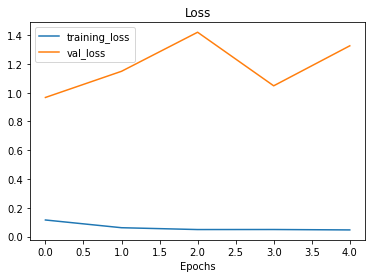

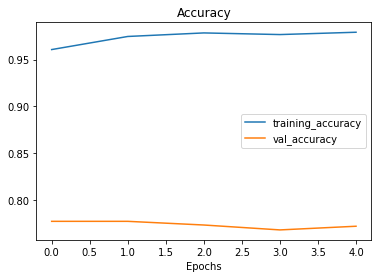

In [86]:
# Plot loss curves
plot_loss_curves(model_2b_history)

In [88]:
# Calculate model 2 results
model_2b_results = calculate_results(y_true=val_labels, 
                                   y_pred=model_2b_preds, 
                                   model_name="model_2b_LSTM")
results_comp = results_comp.append(model_2b_results, ignore_index=True)
results_comp

,model,accuracy,precision,recall,f1
0,baseline,79.265092,0.811139,0.792651,0.786219
1,model_1,78.083990,0.784127,0.780840,0.778263
2,model_2_LSTM,77.034121,0.772347,0.770341,0.768060
3,model_2b_LSTM,77.165354,0.771916,0.771654,0.770400


### Model 3: GRU

Another popular and effective RNN component is the GRU or Gated Recurrent Unit.

The GRU Cell has similar features to an LSTM cell but less parameters.

In [90]:
# Build RNN using GRU Cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [91]:
# Compile and Fit
model_3.compile(loss='binary_crossentropy', 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=['accuracy'])

model_3_history = model_3.fit(train_sentences, 
                              train_labels, 
                              epochs=5, 
                              validation_data=(val_sentences, val_labels), 
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20220122-002753
Epoch 1/5
215/215 [==============================] - 10s 35ms/step - loss: 0.1260 - accuracy: 0.9529 - val_loss: 0.7470 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 7s 31ms/step - loss: 0.0628 - accuracy: 0.9753 - val_loss: 0.8288 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0534 - accuracy: 0.9774 - val_loss: 1.1627 - val_accuracy: 0.7559
Epoch 4/5
215/215 [==============================] - 7s 33ms/step - loss: 0.0456 - accuracy: 0.9796 - val_loss: 1.0745 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 8s 35ms/step - loss: 0.0442 - accuracy: 0.9807 - val_loss: 1.1886 - val_accuracy: 0.7651


In [92]:
# Make predictions with GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

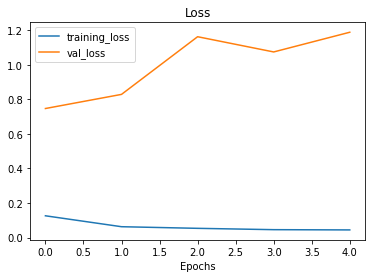

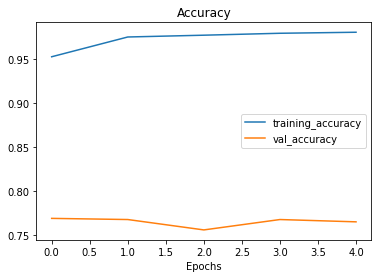

In [93]:
# Plot loss curves
plot_loss_curves(model_3_history)

In [97]:
model_3_results = calculate_results(val_labels, 
                                    model_3_preds, 
                                    "model_3_GRU")
results_comp = results_comp.append(model_3_results, ignore_index=True)
results_comp

,model,accuracy,precision,recall,f1
0,baseline,79.265092,0.811139,0.792651,0.786219
1,model_1,78.083990,0.784127,0.780840,0.778263
2,model_2_LSTM,77.034121,0.772347,0.770341,0.768060
3,model_2b_LSTM,77.165354,0.771916,0.771654,0.770400
4,model_3_GRU,76.509186,0.765634,0.765092,0.763521
